# Convolutional Neural Networks (LeNet)


We now have all the ingredients required to assemble a fully-functional CNN. In our earlier encounter with image data, we applied a softmax regression model and an MLP model to pictures of clothing in the Fashion-MNIST dataset. To make such data amenable to softmax regression and MLPs, we first flattened each image from a $28\times28$ matrix into a fixed-length $784$-dimensional vector, and thereafter processed them with fully-connected layers. Now that we have a handle on convolutional layers, we can retain the spatial structure in our images. As an additional benefit of replacing fully-connected layers with convolutional layers, we will enjoy more parsimonious models that require far fewer parameters.


</br>

In this section, we will introduce *LeNet*, among the first published CNNs to capture wide attention for its performance on computer vision tasks. The model was introduced by (and named for) Yann LeCun, then a researcher at AT&T Bell Labs, for the purpose of recognizing handwritten digits in images This work represented the culmination of a decade of research developing the technology. In 1989, LeCun published the first study to successfully train CNNs via backpropagation.




At the time LeNet achieved outstanding results
matching the performance of support vector machines,
then a dominant approach in supervised learning.
LeNet was eventually adapted to recognize digits
for processing deposits in ATM machines.
To this day, some ATMs still run the code
that Yann and his colleague Leon Bottou wrote in the 1990s!

</br>

## LeNet

At a high level, (**LeNet (LeNet-5) consists of two parts:
(i) a convolutional encoder consisting of two convolutional layers; and
(ii) a dense block consisting of three fully-connected layers**);



The basic units in each convolutional block are a convolutional layer, a sigmoid activation function, and a subsequent average pooling operation. Note that while ReLUs and max-pooling work better, these discoveries had not yet been made in the 1990s. Each convolutional layer uses a $5\times 5$ kernel and a sigmoid activation function. These layers map spatially arranged inputs to a number of two-dimensional feature maps, typically increasing the number of channels. The first convolutional layer has 6 output channels, while the second has 16. Each $2\times2$ pooling operation (stride 2) reduces dimensionality by a factor of $4$ via spatial downsampling. The convolutional block emits an output with shape given by (batch size, number of channel, height, width).



</br>

In order to pass output from the convolutional block to the dense block, we must flatten each example in the minibatch. In other words, we take this four-dimensional input and transform it into the two-dimensional input expected by fully-connected layers: as a reminder, the two-dimensional representation that we desire uses the first dimension to index examples in the minibatch and the second to give the flat vector representation of each example. LeNet's dense block has three fully-connected layers, with 120, 84, and 10 outputs, respectively. Because we are still performing classification, the 10-dimensional output layer corresponds to the number of possible output classes.



While getting to the point where you truly understand what is going on inside LeNet may have taken a bit of work, hopefully the following code snippet will convince you that implementing such models with modern deep learning frameworks is remarkably simple. We need only to instantiate a `Sequential` block and chain together the appropriate layers.


In [ ]:

import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(sub_p_res)

Tesla T4, 15360 MiB, 15109 MiB



In [ ]:
# import the needed modules

import tensorflow as tf
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Define the model

def net(loss, optimizer):
    net = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid',
                               padding='same', input_shape=(28,28,1)),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                               activation='sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='sigmoid'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(10)])
    
    net.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return net

We took a small liberty with the original model,
removing the Gaussian activation in the final layer.
Other than that, this network matches
the original LeNet-5 architecture.

By passing a single-channel (black and white)
$28 \times 28$ image through the network
and printing the output shape at each layer,
we can [**inspect the model**] to make sure
that its operations line up with
what we expect.


In [ ]:
lr = 0.01
num_epochs = 10
batch_size= 256

loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.optimizers.Adam(learning_rate=lr)

In [ ]:
X = tf.random.uniform((1, 28, 28, 1))
for layer in net(loss, optimizer).layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2D output shape: 	 (1, 28, 28, 6)
AveragePooling2D output shape: 	 (1, 14, 14, 6)
Conv2D output shape: 	 (1, 10, 10, 16)
AveragePooling2D output shape: 	 (1, 5, 5, 16)
Flatten output shape: 	 (1, 400)
Dense output shape: 	 (1, 120)
Dense output shape: 	 (1, 84)
Dense output shape: 	 (1, 10)


Note that the height and width of the representation
at each layer throughout the convolutional block
is reduced (compared with the previous layer).
The first convolutional layer uses 2 pixels of padding
to compensate for the reduction in height and width
that would otherwise result from using a $5 \times 5$ kernel.
In contrast, the second convolutional layer forgoes padding,
and thus the height and width are both reduced by 4 pixels.
As we go up the stack of layers,
the number of channels increases layer-over-layer
from 1 in the input to 6 after the first convolutional layer
and 16 after the second convolutional layer.
However, each pooling layer halves the height and width.
Finally, each fully-connected layer reduces dimensionality,
finally emitting an output whose dimension
matches the number of classes.



## Training

Now that we have implemented the model,
let us [**run an experiment to see how LeNet fares on MNIST**].



#### MNIST digits classification dataset

This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

11490434/11490434 [==============================] - 2s 0us/step


**Have a look at the data!**


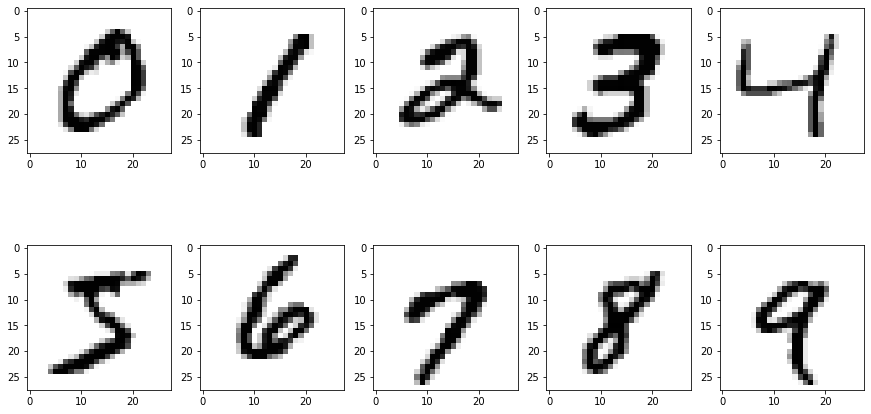

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(15, 8))
ax = ax.flatten()
for i in range(10):
    im_idx = np.argwhere(y_train == i)[0]
    plottable_image = np.reshape(x_train[im_idx], (28, 28))
    ax[i].imshow(plottable_image, cmap='gray_r')

Normalize the data between `[0,1]`

In [ ]:
x_train = x_train/255.0
x_test = x_test/255.0

While CNNs have fewer parameters,
they can still be more expensive to compute
than similarly deep MLPs
because each parameter participates in many more
multiplications.
If you have access to a GPU, this might be a good time
to put it into action to speed up training.





### **Building the model**


Building the neural network requires configuring the layers of the model, then compiling the model. First we stack a few layers together using `keras.Sequential`. Next we configure the loss function, optimizer, and metrics to monitor. These are added during the model's compile step:

* Loss function - measures how accurate the model is during training, we want to minimize this with the optimizer.
* Optimizer - how the model is updated based on the data it sees and its loss function.
* Metrics - used to monitor the training and testing steps.



In [ ]:
lenet = net(loss, optimizer)

lenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

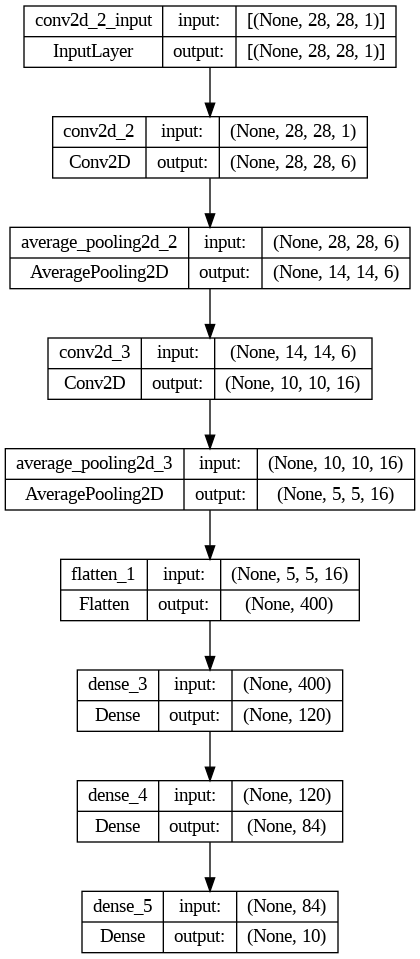

In [ ]:
tf.keras.utils.plot_model(lenet, show_shapes=True)

In [ ]:
history = lenet.fit(x_train, y_train, 
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_test, y_test))

Epoch 1/10
235/235 [==============================] - 5s 7ms/step - loss: 1.8756 - accuracy: 0.3007 - val_loss: 0.6242 - val_accuracy: 0.8052
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2297 - accuracy: 0.9333 - val_loss: 0.0970 - val_accuracy: 0.9702
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0865 - accuracy: 0.9737 - val_loss: 0.0683 - val_accuracy: 0.9785
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0617 - accuracy: 0.9808 - val_loss: 0.0461 - val_accuracy: 0.9852
Epoch 5/10
235/235 [==============================] - 2s 6ms/step - loss: 0.0458 - accuracy: 0.9858 - val_loss: 0.0409 - val_accuracy: 0.9867
Epoch 6/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0392 - accuracy: 0.9879 - val_loss: 0.0371 - val_accuracy: 0.9876
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0337 - accuracy: 0.9897 - val_loss: 0.0356 - val_accuracy: 0.9888
Epoch 

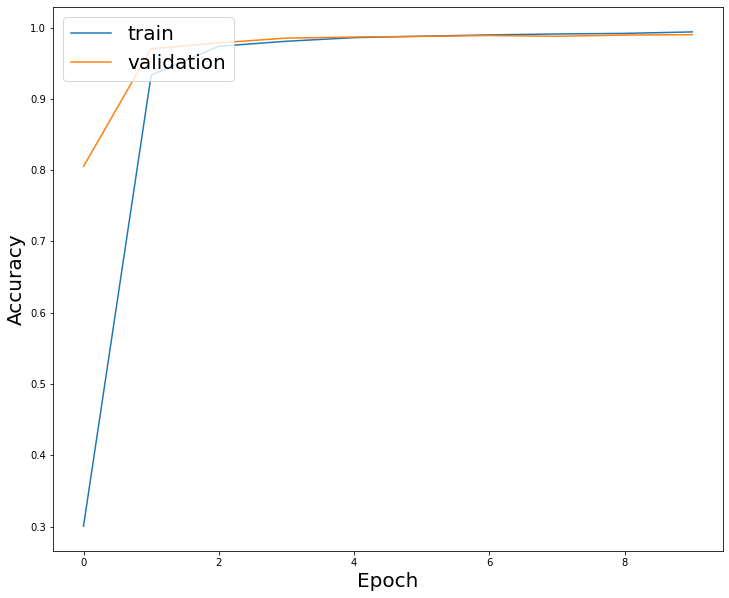

In [ ]:
def plot_history(hist_):
    plt.figure(figsize=(12, 10))
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Error')
    plt.legend(["train", "validation"], loc="upper left", prop={'size': 20})

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_history(hist)

### Evaluate the trained model


In [ ]:
score = lenet.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.033687278628349304
Test accuracy: 0.9900000095367432


### Predict using the trained model


1/1 [==============================] - 0s 28ms/step


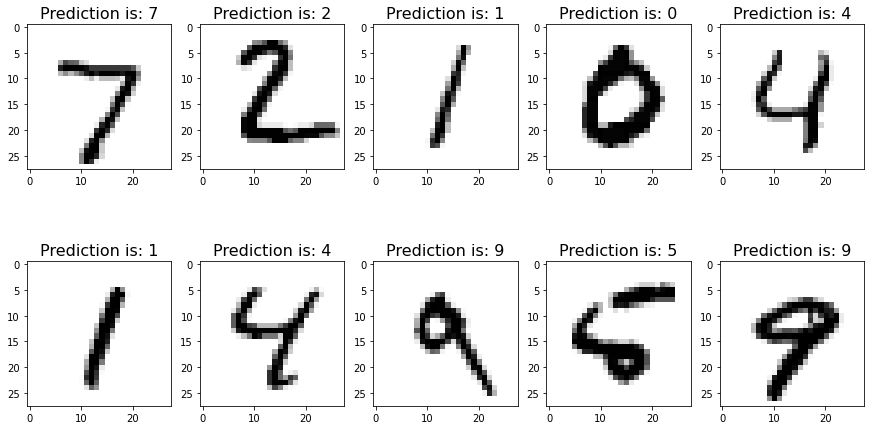

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(15, 8))
ax = ax.flatten()
for i in range(10):
    plottable_image = np.reshape(x_test[i], (28, 28))
    ax[i].imshow(plottable_image, cmap='gray_r')
    ax[i].set_title("Prediction is: {}".format(lenet.predict(np.reshape(x_test[i], (1,28,28,1))).argmax()), fontsize=16)

## Summary

* A CNN is a network that employs convolutional layers.
* In a CNN, we interleave convolutions, nonlinearities, and (often) pooling operations.
* In a CNN, convolutional layers are typically arranged so that they gradually decrease the spatial resolution of the representations, while increasing the number of channels.
* In traditional CNNs, the representations encoded by the convolutional blocks are processed by one or more fully-connected layers prior to emitting output.
* LeNet was arguably the first successful deployment of such a network.

## Exercises

1. Replace the average pooling with maximum pooling. What happens?
1. Try to construct a more complex network based on LeNet to improve its accuracy.
    1. Adjust the convolution window size.
    1. Adjust the number of output channels.
    1. Adjust the activation function (e.g., ReLU).
    1. Adjust the number of convolution layers.
    1. Adjust the number of fully connected layers.
    1. Adjust the learning rates and other training details (e.g., initialization and number of epochs.)
1. Try out the improved network on the original MNIST dataset.
1. Display the activations of the first and second layer of LeNet for different inputs (e.g., sweaters and coats).
